In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 767.4710, train_label_loss: 2.8071, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11686.4816, train_label_loss: 2.6686, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11758.5510, train_label_loss: 2.6543, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11727.5776, train_label_loss: 2.3586, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11707.6806, train_label_loss: 2.3414, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11702.8735, train_label_loss: 2.1506, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11706.9402, train_label_loss: 2.0807, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11591.0029, train_label_loss: 2.0326, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11675.0662, train_label_loss: 1.8375, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11582.7934, train_label_loss: 1.7466, 


epoch: 1, source_val_acc_label: 0.5363, source_val_label_loss: 1.6287, target_val_acc_label: 0.5363, target_val_label_loss: 1.6287, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 55.8246, train_label_loss: 1.4859, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11496.4963, train_label_loss: 1.4072, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11611.2511, train_label_loss: 1.3189, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11593.7437, train_label_loss: 1.2831, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11577.7959, train_label_loss: 1.3837, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11733.6376, train_label_loss: 0.9988, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11698.7769, train_label_loss: 1.0475, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11598.9770, train_label_loss: 0.9300, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11655.3359, train_label_loss: 0.9556, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11624.0924, train_label_loss: 0.7619, 


epoch: 2, source_val_acc_label: 0.8281, source_val_label_loss: 0.7250, target_val_acc_label: 0.8281, target_val_label_loss: 0.7250, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 63.9537, train_label_loss: 0.8217, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11479.8684, train_label_loss: 0.7972, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11692.5273, train_label_loss: 0.6595, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11715.0765, train_label_loss: 0.7801, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11707.3760, train_label_loss: 0.5922, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11676.4881, train_label_loss: 0.6400, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11631.4353, train_label_loss: 0.5769, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11612.5643, train_label_loss: 0.5364, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11689.9450, train_label_loss: 0.5597, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11463.6591, train_label_loss: 0.4795, 


epoch: 3, source_val_acc_label: 0.9024, source_val_label_loss: 0.4804, target_val_acc_label: 0.9024, target_val_label_loss: 0.4804, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 63.9082, train_label_loss: 0.3784, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11521.5679, train_label_loss: 0.5744, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11671.8299, train_label_loss: 0.5427, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 11707.2557, train_label_loss: 0.4739, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 11716.4498, train_label_loss: 0.3700, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11601.9473, train_label_loss: 0.3285, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11977.0841, train_label_loss: 0.4279, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11951.8642, train_label_loss: 0.4635, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11634.3646, train_label_loss: 0.3826, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11670.4780, train_label_loss: 0.2992, 


epoch: 4, source_val_acc_label: 0.9138, source_val_label_loss: 0.3753, target_val_acc_label: 0.9138, target_val_label_loss: 0.3753, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 63.4355, train_label_loss: 0.3597, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11772.0381, train_label_loss: 0.3018, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11753.7425, train_label_loss: 0.3129, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11762.2459, train_label_loss: 0.2830, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11636.7999, train_label_loss: 0.2190, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11786.9871, train_label_loss: 0.3281, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11736.8257, train_label_loss: 0.2635, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11781.3391, train_label_loss: 0.2802, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11679.7142, train_label_loss: 0.3023, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11773.9109, train_label_loss: 0.5163, 


epoch: 5, source_val_acc_label: 0.9277, source_val_label_loss: 0.3004, target_val_acc_label: 0.9277, target_val_label_loss: 0.3004, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 65.0953, train_label_loss: 0.2224, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11813.7139, train_label_loss: 0.2514, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11783.3875, train_label_loss: 0.2385, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11710.2142, train_label_loss: 0.2340, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11677.3008, train_label_loss: 0.2708, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11684.2952, train_label_loss: 0.1937, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11753.8914, train_label_loss: 0.2055, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11765.4993, train_label_loss: 0.1807, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11779.9838, train_label_loss: 0.2265, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11656.6138, train_label_loss: 0.2868, 


epoch: 6, source_val_acc_label: 0.9370, source_val_label_loss: 0.2705, target_val_acc_label: 0.9370, target_val_label_loss: 0.2705, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 63.6425, train_label_loss: 0.1634, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11683.1938, train_label_loss: 0.2054, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11747.7224, train_label_loss: 0.2268, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11728.6793, train_label_loss: 0.1492, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11739.9991, train_label_loss: 0.3960, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11738.3251, train_label_loss: 0.1622, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11742.6366, train_label_loss: 0.1254, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 11783.9842, train_label_loss: 0.2772, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11812.0090, train_label_loss: 0.2056, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11790.2912, train_label_loss: 0.1775, 


epoch: 7, source_val_acc_label: 0.9320, source_val_label_loss: 0.2552, target_val_acc_label: 0.9320, target_val_label_loss: 0.2552, 


epoch: 8, [batch: 1 / 1400], examples_per_second: 64.8347, train_label_loss: 0.1689, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 11720.9824, train_label_loss: 0.1789, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11747.1330, train_label_loss: 0.1833, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11794.3893, train_label_loss: 0.2125, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11739.1923, train_label_loss: 0.1239, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11750.3927, train_label_loss: 0.2427, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11723.1272, train_label_loss: 0.1409, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11733.9032, train_label_loss: 0.2362, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11773.8187, train_label_loss: 0.1107, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11815.5909, train_label_loss: 0.1706, 


epoch: 8, source_val_acc_label: 0.9407, source_val_label_loss: 0.3856, target_val_acc_label: 0.9407, target_val_label_loss: 0.3856, 


New best
epoch: 9, [batch: 1 / 1400], examples_per_second: 64.6598, train_label_loss: 0.1791, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11789.3208, train_label_loss: 0.4597, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11681.5966, train_label_loss: 0.1916, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11756.9857, train_label_loss: 0.1370, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11824.9003, train_label_loss: 0.2212, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11776.7999, train_label_loss: 0.1310, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11841.1244, train_label_loss: 0.1516, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11755.2205, train_label_loss: 0.1431, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11751.6034, train_label_loss: 0.1655, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11758.1665, train_label_loss: 0.2678, 


epoch: 9, source_val_acc_label: 0.9473, source_val_label_loss: 0.2884, target_val_acc_label: 0.9473, target_val_label_loss: 0.2884, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 64.4977, train_label_loss: 0.1354, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11788.4418, train_label_loss: 0.1211, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11759.1580, train_label_loss: 0.1363, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11781.3299, train_label_loss: 0.1341, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11717.2973, train_label_loss: 0.0936, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11770.9091, train_label_loss: 0.1000, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11815.8491, train_label_loss: 0.1108, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11730.6856, train_label_loss: 0.2823, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11770.6160, train_label_loss: 0.1814, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11789.2390, train_label_loss: 0.1694, 


epoch: 10, source_val_acc_label: 0.9503, source_val_label_loss: 0.2828, target_val_acc_label: 0.9503, target_val_label_loss: 0.2828, 


New best
epoch: 11, [batch: 1 / 1400], examples_per_second: 64.0667, train_label_loss: 0.1566, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 12660.2969, train_label_loss: 0.1515, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 12536.6328, train_label_loss: 0.1635, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 12696.3831, train_label_loss: 0.0898, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 12677.0889, train_label_loss: 0.1438, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 12776.3634, train_label_loss: 0.1160, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 12795.6170, train_label_loss: 0.1374, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 12562.4559, train_label_loss: 0.1327, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 12140.7267, train_label_loss: 0.1487, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 10730.2397, train_label_loss: 0.1072, 


epoch: 11, source_val_acc_label: 0.9608, source_val_label_loss: 0.2395, target_val_acc_label: 0.9608, target_val_label_loss: 0.2395, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 57.6908, train_label_loss: 0.1102, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 10662.2395, train_label_loss: 0.0785, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 10716.1849, train_label_loss: 0.1271, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 10744.1948, train_label_loss: 0.1069, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 10770.4728, train_label_loss: 0.1426, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 10741.5062, train_label_loss: 0.1291, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 10730.7284, train_label_loss: 0.1325, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 10727.1401, train_label_loss: 0.1743, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 10789.8910, train_label_loss: 0.1295, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 10746.1672, train_label_loss: 0.1345, 


epoch: 12, source_val_acc_label: 0.9376, source_val_label_loss: 0.3144, target_val_acc_label: 0.9376, target_val_label_loss: 0.3144, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 57.7369, train_label_loss: 0.1745, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 10658.2847, train_label_loss: 0.1310, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 10739.3329, train_label_loss: 0.1477, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 10778.1829, train_label_loss: 0.1030, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 10763.7171, train_label_loss: 0.0963, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 10695.2971, train_label_loss: 0.1170, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 10726.1925, train_label_loss: 0.1663, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 10692.4671, train_label_loss: 0.1336, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 10712.0781, train_label_loss: 0.1777, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 10622.5445, train_label_loss: 0.1802, 


epoch: 13, source_val_acc_label: 0.9534, source_val_label_loss: 0.2689, target_val_acc_label: 0.9534, target_val_label_loss: 0.2689, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 57.5954, train_label_loss: 0.1436, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 10568.7830, train_label_loss: 0.1103, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 10736.4811, train_label_loss: 0.0828, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 10771.2199, train_label_loss: 0.0737, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 10744.9044, train_label_loss: 0.1169, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 10695.1069, train_label_loss: 0.1161, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 10729.8062, train_label_loss: 0.1606, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 10704.8830, train_label_loss: 0.1465, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 10721.4678, train_label_loss: 0.0853, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 10750.2694, train_label_loss: 0.1277, 


epoch: 14, source_val_acc_label: 0.9480, source_val_label_loss: 0.3495, target_val_acc_label: 0.9480, target_val_label_loss: 0.3495, 


epoch: 15, [batch: 1 / 1400], examples_per_second: 57.3366, train_label_loss: 0.1067, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 10659.6031, train_label_loss: 0.1111, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 10703.5629, train_label_loss: 0.0686, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 10703.6909, train_label_loss: 0.1211, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10703.1041, train_label_loss: 0.1372, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10710.6126, train_label_loss: 0.1018, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10708.1391, train_label_loss: 0.0474, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10885.1294, train_label_loss: 0.2392, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10716.1757, train_label_loss: 0.1018, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10675.4897, train_label_loss: 0.0903, 


epoch: 15, source_val_acc_label: 0.9602, source_val_label_loss: 0.1456, target_val_acc_label: 0.9602, target_val_label_loss: 0.1456, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

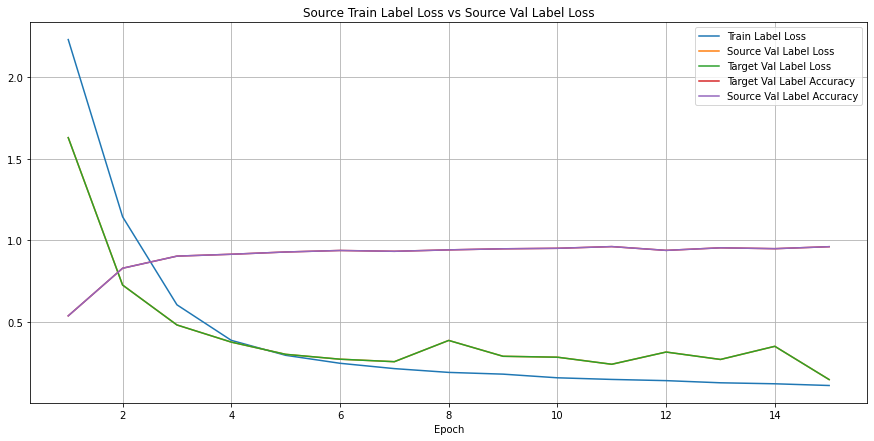

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

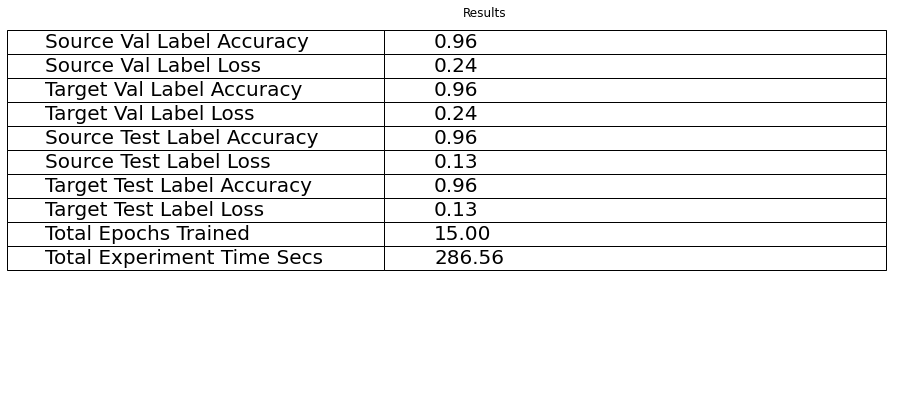

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

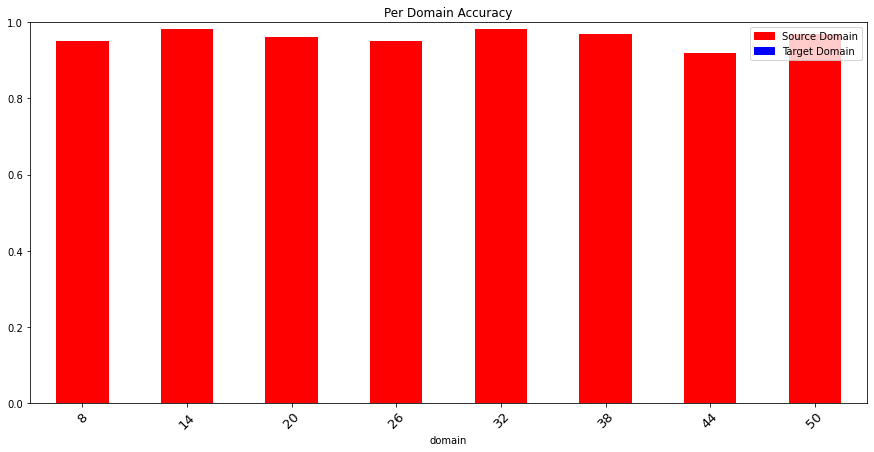

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.96203125 Target Test Label Accuracy: 0.96203125
Source Val Label Accuracy: 0.9608072916666667 Target Val Label Accuracy: 0.9608072916666667


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1.framed", "parameters": {"experiment_name": "cnn_2:oracle.run1.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch